In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator


import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

import datetime as dt
import warnings
warnings.filterwarnings("ignore")

## Giới thiệu Dataset:
##### -Dataset chứa tất cả các giao dịch xảy ra từ ngày 12/01/2010 đến ngày 12/09/2011 trong lĩnh vực Ecommerce. Gồm 8 cột và 541909 dòng.
##### -Dataset có các cột InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID and Country.
##### -Từ thông tin trên tính điểm RFM từ đó tạo phân khúc khách hàng bằng thuật toán K-means

In [2]:
# Load Dataset
data = pd.read_csv('D:\DA15\Final project\E-Commerce.data.utf8.csv')
df = data.copy()


## 1. Data cleaning /Exploratory Data Analysis

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Convert Dtype column (Invoice Date) to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
# Check null values
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [9]:
# delete NA values in CustomerID & Description 
df = df.dropna()

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df.loc[df.Quantity < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


#### Nhận xét: Quantity bị âm ứng cột InvoiceNo có chứa "C" có thể đơn hàng bị Cancel hoặc bị trả. 

## 2. Tính RFM 
##### R = Recency: là lần gần nhất khách hàng mua
##### F = Frequency: là tần suất khách hàng mua
##### M = Monetary : là chi tiêu khách hàng dành cho mua sắm

##### Các cột cần thiết để tính toán

Customer ID <br>
Unit Price <br>
Quantity <br>
Invoice Date <br>

In [12]:
# R = Recency
df_recency = df.groupby(by='CustomerID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [13]:
# F = Frequency
frequency_df = df.groupby(
    by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [14]:
# M = Monetary
df['Revenue'] = df['UnitPrice']*df['Quantity']
monetary_df = df.groupby(by='CustomerID', as_index=False)['Revenue'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [15]:
# Merge dataframe
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [16]:
# delete columns CustomerID
rfm_df1 = rfm_df.copy()
rfm_df1 = rfm_df1.drop('CustomerID', axis=1)

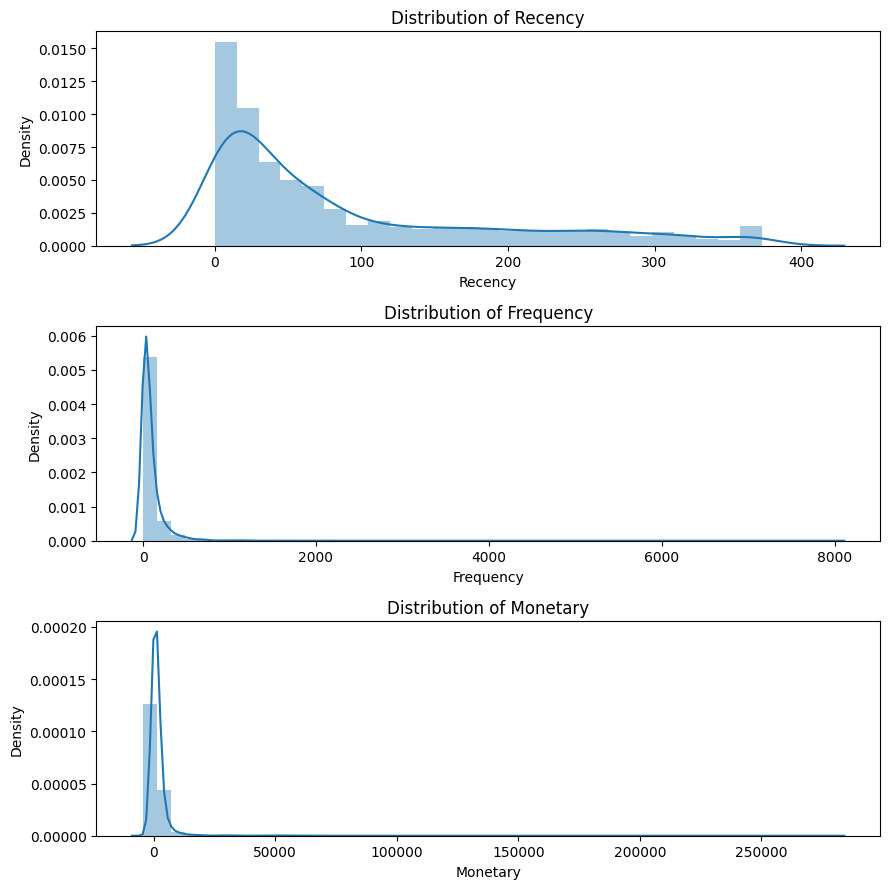

In [17]:
# Vizualize R,F,M score and check distribution

count=1
column = rfm_df1.columns
plt.subplots(figsize=(9,9))
for col in column:
    plt.subplot(3,1,count)
    plt.title('Distribution of ' + col)
    sns.distplot(rfm_df1[col])
    count+=1
plt.tight_layout()
plt.show()

##### Nhận xét 3 biến R, F, M phân phối lệch chuẩn rất lớn sẽ gây ảnh hưởng model

In [18]:
# Use Log Transform to remove skewness
df_log = np.log(rfm_df1+1)
df_log

,Recency,Frequency,Monetary
0,5.786897,1.098612,0.000000
1,0.693147,5.209486,8.368925
2,4.317488,3.465736,7.494564
3,2.944439,4.304065,7.472245
4,5.736572,2.890372,5.815324
...,...,...,...
4367,5.627621,2.397895,5.201806
4368,5.198497,2.079442,4.404522
4369,2.079442,2.639057,5.179534
4370,1.386294,6.629363,7.647729


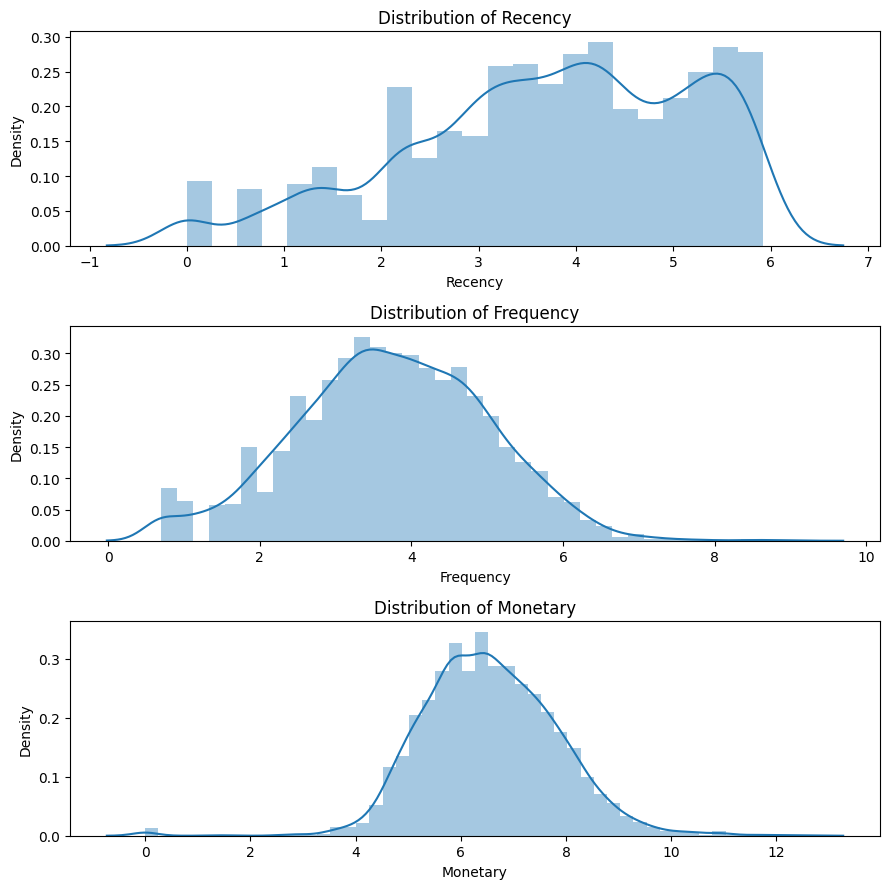

In [19]:
# Vizualize R,F,M score after tranforming
count=1
column = df_log.columns
plt.subplots(figsize=(9,9))
for col in column:
    plt.subplot(3,1,count)
    plt.title('Distribution of ' + col)
    sns.distplot(df_log[col])
    count+=1
plt.tight_layout()
plt.show()

In [21]:
# Vizualize and Check outliners

fig = go.Figure()
for i in ["Recency", "Frequency","Monetary"]:
    fig.add_trace(go.Box(
        y= df_log[i],
        name= i,
        boxpoints='suspectedoutliers', # only suspected outliers
        marker=dict(
            color='rgb(8,81,156)',
            outliercolor='rgba(219, 64, 82, 0.6)',
            line=dict(
                outliercolor='rgba(219, 64, 82, 0.6)',
                outlierwidth=2)),
        line_color='rgb(8,81,156)'
    ))

fig.update_layout(title_text="Box Plot Styling Outliers")
fig.show()

In [24]:
# Loại bỏ outliners
#! pip install feature-engine
from feature_engine.outliers import Winsorizer
df_log = df_log.fillna(0)

In [25]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_log)
df_log = windsoriser.transform(df_log)

In [26]:
# # Vizualize and Re-check outliners
fig = go.Figure()
for i in ["Recency", "Frequency","Monetary"]:
    fig.add_trace(go.Box(
        y= df_log[i],
        name= i,
        boxpoints='suspectedoutliers', # only suspected outliers
        marker=dict(
            color='rgb(8,81,156)',
            outliercolor='rgba(219, 64, 82, 0.6)',
            line=dict(
                outliercolor='rgba(219, 64, 82, 0.6)',
                outlierwidth=2)),
        line_color='rgb(8,81,156)'
    ))

fig.update_layout(title_text="Box Plot Styling Outliers")
fig.show()

In [28]:
# Normalizing data
rfm_normalized = df_log
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized, columns=df_log.columns)
rfm_normalized

,Recency,Frequency,Monetary
0,1.436811,-2.079531,-2.360337
1,-2.085357,1.205318,1.497977
2,0.398327,-0.229491,0.788086
3,-0.572056,0.460311,0.769966
4,1.401245,-0.702918,-0.575282
...,...,...,...
4367,1.324245,-1.108142,-1.073394
4368,1.020967,-1.370176,-1.720706
4369,-1.183381,-0.909707,-1.091477
4370,-1.673253,2.076113,0.912440


## 3. K-Means Clustering
### Tìm số cụm tối ưu


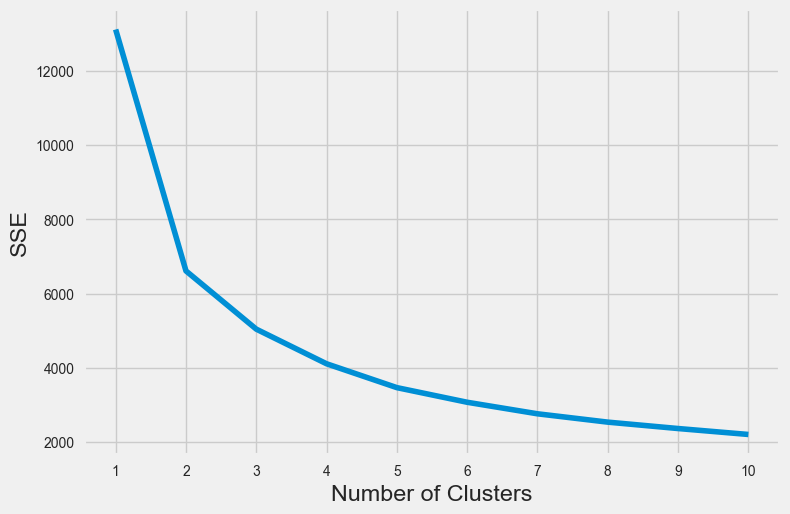

In [33]:
# Elbow Curve
sse = []
range_n_clusters = range(1, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters= k, random_state = 1)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11),sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [34]:
# Chọn vị trị Elbow
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(f'Vị trí elbow: {kl.elbow}')

Vị trí elbow: 3


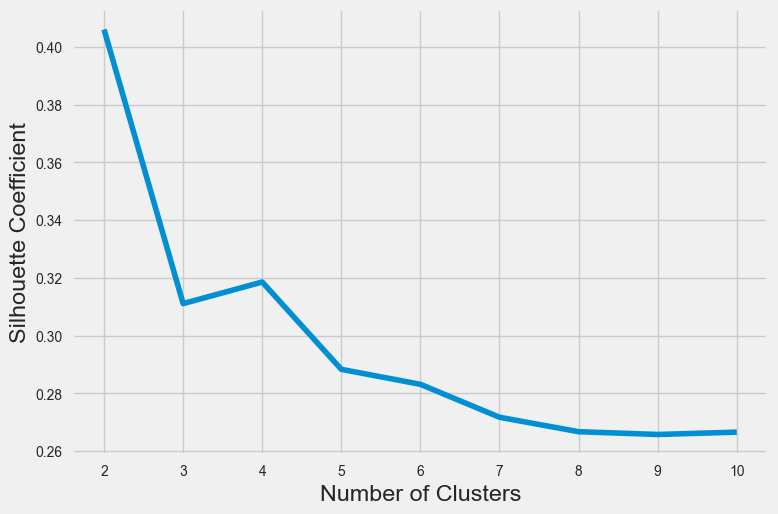

In [35]:
# Silhouette score
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
 kmeans = KMeans(n_clusters=k)
 kmeans.fit(rfm_normalized)
 score = silhouette_score(rfm_normalized, kmeans.labels_)
 silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Từ 2 phương pháp trên chọn phân chia khách hàng thành 3 nhóm (k=3)

In [37]:
from sklearn.manifold import TSNE

In [41]:
def kmeans(normalised_df_rfm, clusters_number):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = rfm_normalized.assign(Cluster = cluster_labels)
    
    # Dimensionality reduction 
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Vizualize Clusters
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1],  palette="Set1") #hue=cluster_labels, style=cluster_labels,
    
    return df_new

### Phân chia 3 cụm hợp lý nhất

In [ ]:
rfm_values = df_rfm_k3.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    


In [ ]:
rfm_values

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         171.0      15.0    261.0  1526
1          13.0     253.0   5655.0  1083
2          69.0      63.0   1008.0  1763

### Customer Segmentation <br>
Cluster 0 : Low value (Không giao dịch khoảng thời gian dài, Tần suất thấp, Chi tiêu ít) <br>
Cluster 1 : High value (Có giao dịch thời gian gần nhất , Tần suất thường xuyên, Chi tiêu cao)<br>
Cluster 2 : Medium value (Không giao dịch một thời gian, Tần suất trung bình, Chi tiêu trung bình)

In [ ]:
df_rfm_k3['Cust_Segmen'] = df_rfm_k3.Cluster.map({0:'Low value', 1: 'High value', 2:'Medium value'})

In [ ]:
df_rfm_k3

,Recency,Frequency,Monetary,Cluster,Cust_Segmen
0,325,2,0.00,0,Low value
1,1,182,4310.00,1,High value
2,74,31,1797.24,2,Medium value
3,18,73,1757.55,2,Medium value
4,309,17,334.40,0,Low value
...,...,...,...,...,...
4367,277,10,180.60,0,Low value
4368,180,7,80.82,0,Low value
4369,7,13,176.60,0,Low value
4370,3,756,2094.88,1,High value


In [ ]:
labels = list(df_rfm_k3.Cust_Segmen.value_counts().index)
values = list(df_rfm_k3.Cust_Segmen.value_counts())

fig = go.Figure(data=[go.Pie(labels=labels, values=values)], 
                layout=go.Layout(title=go.layout.Title(text="Customer Segmentation")))
fig.show()

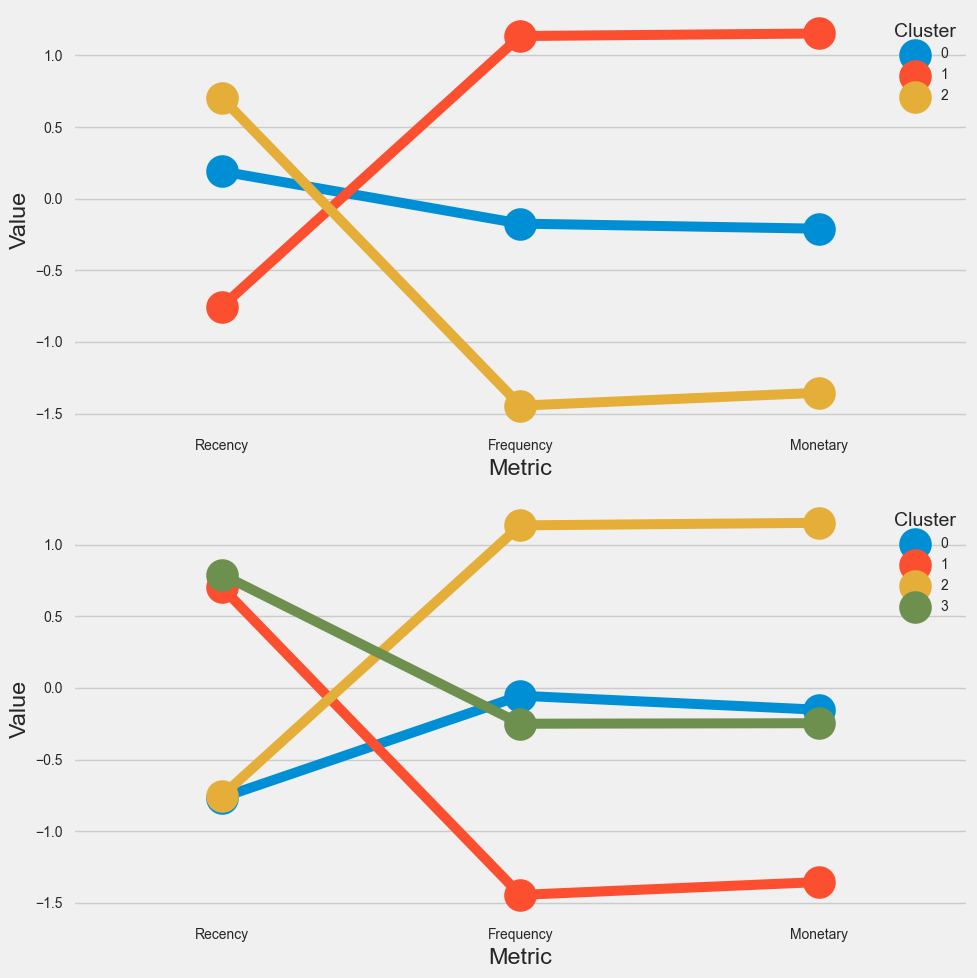

In [66]:
def snake_plot(normalised_df_rfm, clusters_number, df_rfm_original):
    # Build and fit model
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
    #                                    index=df_rfm_original.index, 
    #                                    columns=df_rfm_original.columns)
    normalised_df_rfm['Cluster'] = cluster_labels



    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
df_rfm_k3 = snake_plot(rfm_normalized, 3, rfm_df1)
plt.subplot(2, 1, 2)
df_rfm_k4 = snake_plot(rfm_normalized, 4, rfm_df1)
plt.tight_layout()